In [22]:
#Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import requests
import datetime
from bs4 import BeautifulSoup
%matplotlib inline

#Turn off chained assignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#Get the list of available movies and metadata from FML
r = requests.get("https://fantasymovieleague.com/researchvault?section=box-office")
soup = BeautifulSoup(r.content, 'lxml')

#Find the relevant table, clean it up
table = soup.find_all('table')[0]
df = pd.read_html(str(table))[0]
df.drop(df.columns[0], axis=1, inplace=True) #The HTML table has an extra column of 1-indexed ranks
df.columns = df.columns.droplevel() #The HTML table has an erroneous multi-index

#Split name column to get FML price and name stored separately
df["price"] = df.iloc[:,0].str.split("$", n=0, expand=True)[1]
df["name"] = df.iloc[:,0].str.split("FB", n=0, expand=True)[0]
firststep = df.drop(df.columns[0], axis = 1) #Drop the old name column
firststep

,Earnings,%Change,Earnings,%Change,Earnings,%Change,Earnings,%Change,price,name
0,$16.9M,-,-,-,-,-,-,-,121,Red Sparrow
1,$13.0M,-,-,-,-,-,-,-,85,Death Wish
2,$10.4M,-38.8%,$17.0M,-,-,-,-,-,97,Game Night
3,$10.0M,-21.6%,$12.8M,-45.4%,$23.4M,-6.5%,$25.0M,-,107,Peter Rabbit
4,$5.6M,-49.3%,$11.1M,-,-,-,-,-,44,Annihilation
5,$4.4M,-21.5%,$5.7M,-43.6%,$10.0M,-0.1%,$10.0M,-8.3%,47,Jumanji: Welcome to the Jungle
6,$3.4M,-52.4%,$7.1M,-63.2%,$19.4M,-49.6%,$38.6M,-,25,Fifty Shades Freed
7,$2.7M,-20.8%,$3.4M,-47.7%,$6.5M,+1.3%,$6.4M,-16.3%,29,The Greatest Showman
8,$1.5M,+23.8%,$1.2M,-42.6%,$2.1M,-35.3%,$3.2M,-28.6%,48,The Shape of Water
9,-,-,-,-,-,-,-,-,47,Thoroughbreds


In [4]:
#Deal with the special case of Blockbuster movies being split by day
firststep["day"] = 'ALL'
cleaned = firststep
days = ['FRI','SAT','SUN']

#If movie is split by day, store that row's day in "day" column
try:
    cleaned.loc[cleaned.name.str.contains('|'.join(days)),"day"] = cleaned[
        cleaned.name.str.contains('|'.join(days))].name.str.split(" - ", n=0, expand=True)[0]
    
    #If movie is split by day, store that row's cleaned name in "name" column
    cleaned.loc[cleaned.name.str.contains('|'.join(days)),"name"] = cleaned[
        cleaned.name.str.contains('|'.join(days))].name.str.split(" - ", n=0, expand=True)[1]
except KeyError:
    print("Looks like no movies are split by day this week! Yay!")

#Rename columns, drop irrelevant columns
cleaned.columns.values[[0,2,4,6]] = ["lastweek","2weeksago","3weeksago","4weeksago"]
final = cleaned.drop(cleaned.columns[[1,3,5,7]], axis = 1)
final

Looks like no movies are split by day this week! Yay!


,lastweek,2weeksago,3weeksago,4weeksago,price,name,day
0,$16.9M,-,-,-,121,Red Sparrow,ALL
1,$13.0M,-,-,-,85,Death Wish,ALL
2,$10.4M,$17.0M,-,-,97,Game Night,ALL
3,$10.0M,$12.8M,$23.4M,$25.0M,107,Peter Rabbit,ALL
4,$5.6M,$11.1M,-,-,44,Annihilation,ALL
5,$4.4M,$5.7M,$10.0M,$10.0M,47,Jumanji: Welcome to the Jungle,ALL
6,$3.4M,$7.1M,$19.4M,$38.6M,25,Fifty Shades Freed,ALL
7,$2.7M,$3.4M,$6.5M,$6.4M,29,The Greatest Showman,ALL
8,$1.5M,$1.2M,$2.1M,$3.2M,48,The Shape of Water,ALL
9,-,-,-,-,47,Thoroughbreds,ALL


In [5]:
#Before getting daily numbers from the-numbers.com, we need movie names in the format the-numbers uses for URLs.
#Luckily, the-numbers.com has consistent URL conventions!

final["url_part"] = final["name"]

the_mask = final["url_part"].str.startswith("The ")
final.loc[the_mask, "url_part"] = final.loc[the_mask, "url_part"].str.replace("The ","") + " The" #Move "The" to end
final["url_part"] = final["url_part"].str.replace(' ', '-')

#colons with a space after are removed (as in "Jumani: "), and other string cleaning
final["url_part"] = final["url_part"].str.replace(': ',' ')
final["url_part"] = final["url_part"].str.replace(',','')
final["url_part"] = final["url_part"].str.replace('!','')
final["url_part"] = final["url_part"].str.replace('.','')
final["url_part"] = final["url_part"].str.replace('\'','')
#colons within words or numbers (as in "15:17") are replaced with dashes
final["url_part"] = final["url_part"].str.replace(':', '-')
final

,lastweek,2weeksago,3weeksago,4weeksago,price,name,day,url_part
0,$16.9M,-,-,-,121,Red Sparrow,ALL,Red-Sparrow
1,$13.0M,-,-,-,85,Death Wish,ALL,Death-Wish
2,$10.4M,$17.0M,-,-,97,Game Night,ALL,Game-Night
3,$10.0M,$12.8M,$23.4M,$25.0M,107,Peter Rabbit,ALL,Peter-Rabbit
4,$5.6M,$11.1M,-,-,44,Annihilation,ALL,Annihilation
5,$4.4M,$5.7M,$10.0M,$10.0M,47,Jumanji: Welcome to the Jungle,ALL,Jumanji--Welcome-to-the-Jungle
6,$3.4M,$7.1M,$19.4M,$38.6M,25,Fifty Shades Freed,ALL,Fifty-Shades-Freed
7,$2.7M,$3.4M,$6.5M,$6.4M,29,The Greatest Showman,ALL,Greatest-Showman-The
8,$1.5M,$1.2M,$2.1M,$3.2M,48,The Shape of Water,ALL,Shape-of-Water-The
9,-,-,-,-,47,Thoroughbreds,ALL,Thoroughbreds


In [6]:
#This function takes in one of the cleaned URL_parts we made above and grabs the associated data from the-numbers.com

def get_table(row):
    try:
        r = requests.get("https://www.the-numbers.com/movie/{}-(2018)".format(row))
        soup = BeautifulSoup(r.content, 'lxml')
        table = soup.find_all(id = 'box_office_chart')[1]   
        movie = pd.read_html(str(table))[0]
        movie.columns = movie.iloc[0]
        movie = movie[1:]
        movie["Gross"] = movie["Gross"].str.replace('\$|,','')
        print("Found and stored data for {}-(2018)!".format(row))
        return movie
    except IndexError: #the-numbers.com sometimes includes movie year, sometimes does not
        print("No luck finding {}-(2018), will try adding -(2017)".format(row))
        try:
            r = requests.get("https://www.the-numbers.com/movie/{}-(2017)".format(row))
            soup = BeautifulSoup(r.content, 'lxml')
            table = soup.find_all(id = 'box_office_chart')[1]   
            movie = pd.read_html(str(table))[0]
            movie.columns = movie.iloc[0]
            movie = movie[1:]
            movie["Gross"] = movie["Gross"].str.replace('\$|,','')
            print("Found and stored data for {}-2017!".format(row))
            return movie
        except IndexError: #the-numbers.com mislabeled "Death With" as from 2017...
            print("No luck finding {}-(2017) either. Will try removing year specification.".format(row))
            try:
                r = requests.get("https://www.the-numbers.com/movie/{}".format(row))
                soup = BeautifulSoup(r.content, 'lxml')
                table = soup.find_all(id = 'box_office_chart')[1]   
                movie = pd.read_html(str(table))[0]
                movie.columns = movie.iloc[0]
                movie = movie[1:]
                movie["Gross"] = movie["Gross"].str.replace('\$|,','')
                print("Found and stored data for {}!".format(row))
                return movie
            except IndexError:
                print("Looks like {} doesn't exist on the-numbers.com. Try a google search?".format(row))

In [26]:
#Incredibly, the forecast part is one of the easiest.

def forecast(df):
    #fbprophet requires one "y" column for values and one "ds" column for dates
    try:
        df["y"] = pd.to_numeric(df["Gross"])
        df["ds"] = pd.to_datetime(df["Date"], format = '%Y/%m/%d')
        m = Prophet(changepoint_prior_scale=.5) #default 0.05, higher values make the trend fit more flexible
        m.fit(df)
        future_data = m.make_future_dataframe(periods=7) #forecast a week to make sure we capture next week's numbers
        fcast_data = m.predict(future_data)
        m.plot(fcast_data)
        plt.ylabel("Forecast of Daily Gross")
        plt.title(row)
        plt.show()
        fcast_data["day"] = fcast_data["ds"].dt.weekday_name
        day_abb = {"Monday" : "MON"
           , "Tuesday" : "TUE"
           , "Wednesday" : "WED"
           , "Thursday" : "THU"
           , "Friday" : "FRI"
           , "Saturday" : "SAT"
           , "Sunday" : "SUN"}
        fcast_data["day"] = fcast_data["day"].map(day_abb)
        return fcast_data
    except TypeError:
        print("This is likely a new movie, which can't be forecasted yet! Moving on. \n")

No luck finding Red-Sparrow-(2018), will try adding -(2017)
No luck finding Red-Sparrow-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 1.0.


Found and stored data for Red-Sparrow!


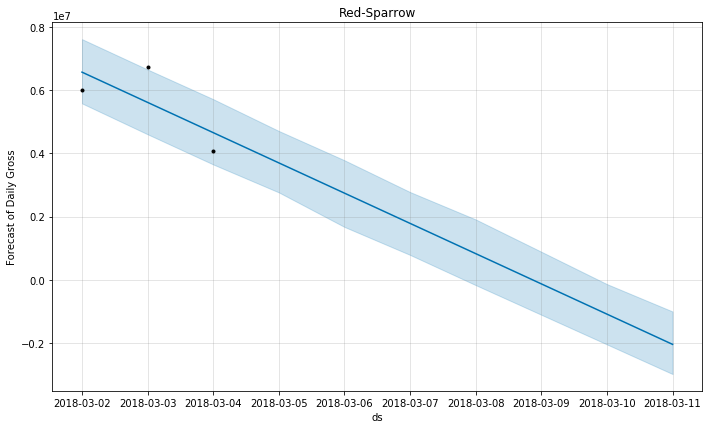

3
setting to new movie
No luck finding Death-Wish-(2018), will try adding -(2017)


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 1.0.


Found and stored data for Death-Wish-2017!


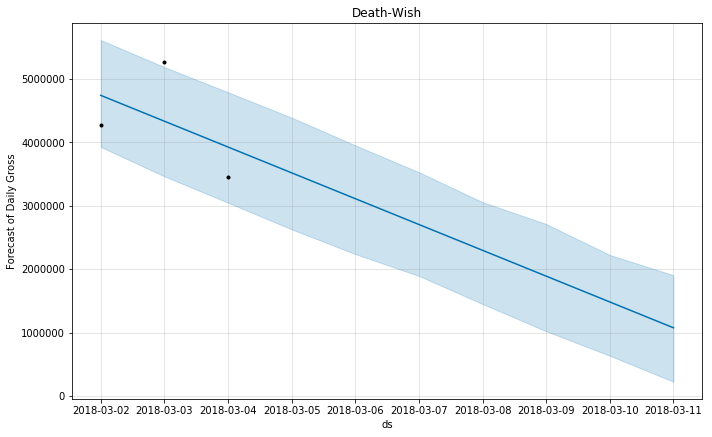

3
setting to new movie


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 7.0.


Found and stored data for Game-Night-(2018)!


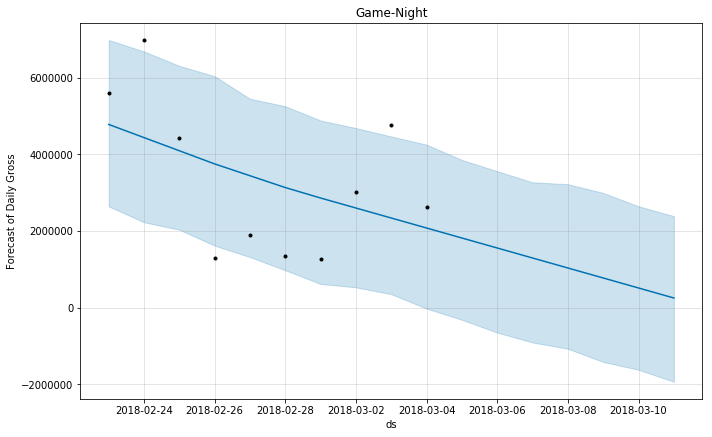

10
setting to weekend_sum


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 18.0.


Found and stored data for Peter-Rabbit-(2018)!


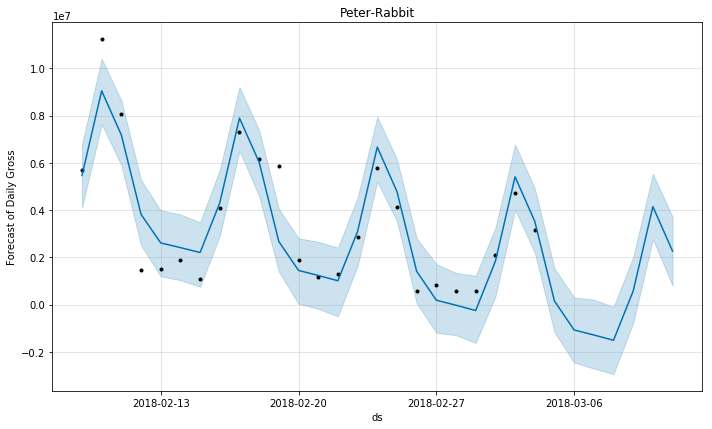

24
setting to weekend_sum
No luck finding Annihilation-(2018), will try adding -(2017)
No luck finding Annihilation-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 7.0.


Found and stored data for Annihilation!


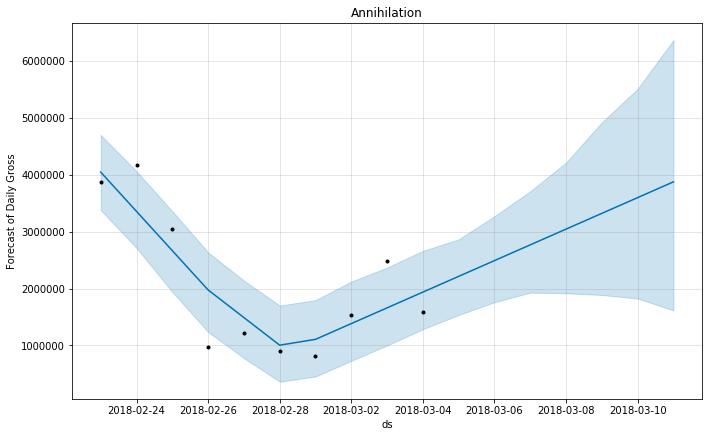

10
setting to weekend_sum
No luck finding Jumanji--Welcome-to-the-Jungle-(2018), will try adding -(2017)
No luck finding Jumanji--Welcome-to-the-Jungle-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Jumanji--Welcome-to-the-Jungle!


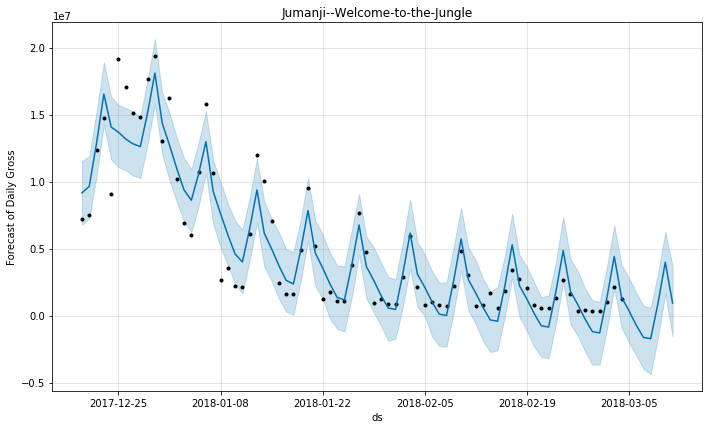

75
setting to weekend_sum
No luck finding Fifty-Shades-Freed-(2018), will try adding -(2017)
No luck finding Fifty-Shades-Freed-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 18.0.


Found and stored data for Fifty-Shades-Freed!


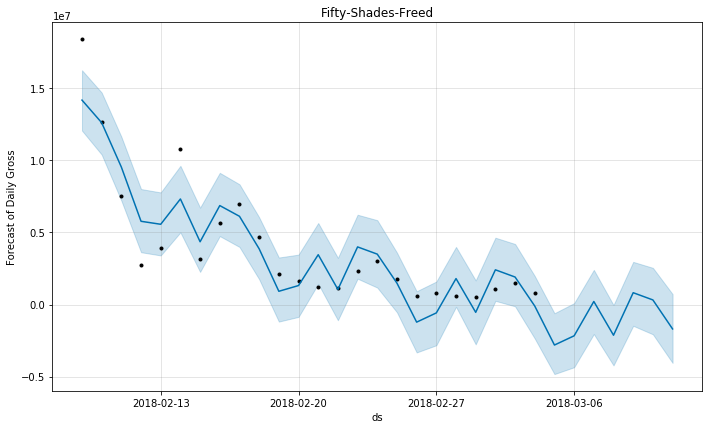

24
setting to weekend_sum
No luck finding Greatest-Showman-The-(2018), will try adding -(2017)
No luck finding Greatest-Showman-The-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Greatest-Showman-The!


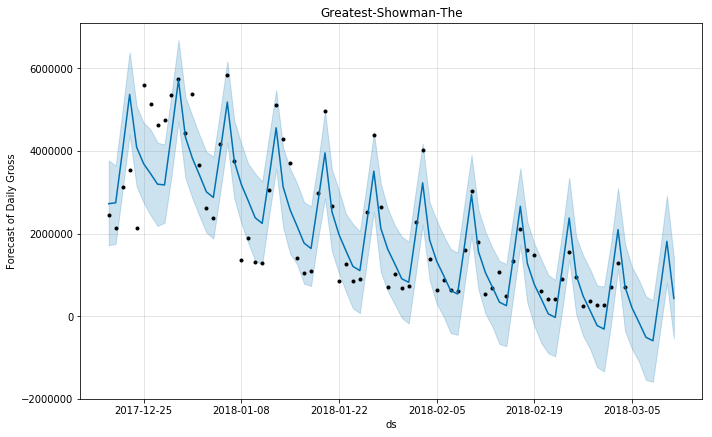

75
setting to weekend_sum
No luck finding Shape-of-Water-The-(2018), will try adding -(2017)
No luck finding Shape-of-Water-The-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Shape-of-Water-The!


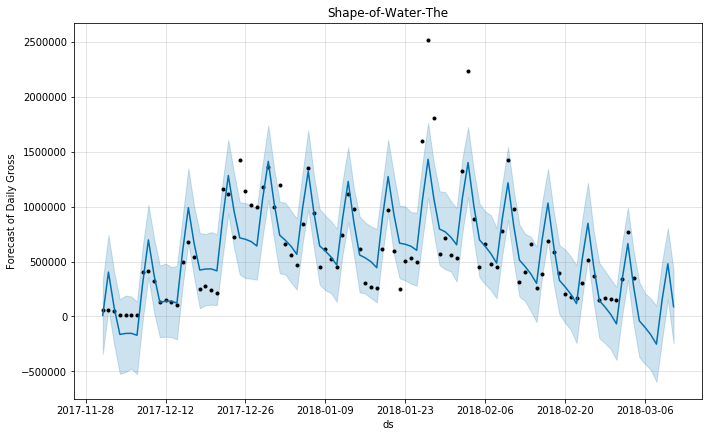

94
setting to weekend_sum
No luck finding Thoroughbreds-(2018), will try adding -(2017)
No luck finding Thoroughbreds-(2017) either. Will try removing year specification.
Looks like Thoroughbreds doesn't exist on the-numbers.com. Try a google search?
This is likely a new movie, which can't be forecasted yet! Moving on. 

No luck finding Black-Panther-(2018), will try adding -(2017)
No luck finding Black-Panther-(2017) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 12.0.


Found and stored data for Black-Panther!


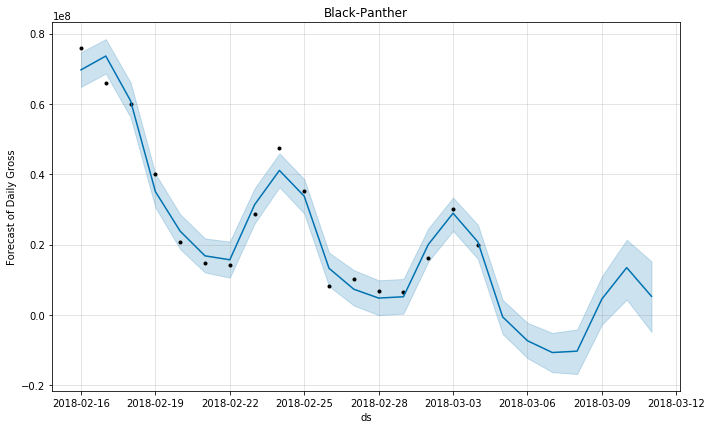

17
setting to weekend_sum
No luck finding A-Wrinkle-in-Time-(2018), will try adding -(2017)
No luck finding A-Wrinkle-in-Time-(2017) either. Will try removing year specification.
Looks like A-Wrinkle-in-Time doesn't exist on the-numbers.com. Try a google search?
This is likely a new movie, which can't be forecasted yet! Moving on. 

No luck finding Strangers--Prey-at-Night-The-(2018), will try adding -(2017)
No luck finding Strangers--Prey-at-Night-The-(2017) either. Will try removing year specification.
Looks like Strangers--Prey-at-Night-The doesn't exist on the-numbers.com. Try a google search?
This is likely a new movie, which can't be forecasted yet! Moving on. 

No luck finding Hurricane-Heist-The-(2018), will try adding -(2017)
No luck finding Hurricane-Heist-The-(2017) either. Will try removing year specification.
Looks like Hurricane-Heist-The doesn't exist on the-numbers.com. Try a google search?
This is likely a new movie, which can't be forecasted yet! Moving on. 

No luck 

In [47]:
weekend_estimates = {}
for row in final["url_part"]:
    movie = get_table(row)
    fcast_data = forecast(movie)
    try:
        weekend_sum = fcast_data[(fcast_data["ds"] >= datetime.date.today())
            & (fcast_data["day"].isin(days))]["yhat"].sum()
        print(fcast_data[fcast_data["ds"] < datetime.date.today()].shape[0])
        if fcast_data[fcast_data["ds"] < datetime.date.today()].shape[0] < 7:
            print("setting to new movie")
            weekend_estimates[row] = "New movie"
        else:
            print("setting to weekend_sum")
            weekend_estimates[row] = weekend_sum
    except TypeError:
        weekend_estimates[row] = "New movie"

In [55]:
estimates = pd.DataFrame.from_dict(weekend_estimates, orient='index')
estimates.reset_index(level=0, inplace=True)
estimates.columns = ["url_part", "estimate"]
merged = final.merge(estimates, on = "url_part")
merged

,lastweek,2weeksago,3weeksago,4weeksago,price,name,day,url_part,estimate
0,$16.9M,-,-,-,121,Red Sparrow,ALL,Red-Sparrow,New movie
1,$13.0M,-,-,-,85,Death Wish,ALL,Death-Wish,New movie
2,$10.4M,$17.0M,-,-,97,Game Night,ALL,Game-Night,1.54248e+06
3,$10.0M,$12.8M,$23.4M,$25.0M,107,Peter Rabbit,ALL,Peter-Rabbit,6.99345e+06
4,$5.6M,$11.1M,-,-,44,Annihilation,ALL,Annihilation,1.07921e+07
5,$4.4M,$5.7M,$10.0M,$10.0M,47,Jumanji: Welcome to the Jungle,ALL,Jumanji--Welcome-to-the-Jungle,5.82677e+06
6,$3.4M,$7.1M,$19.4M,$38.6M,25,Fifty Shades Freed,ALL,Fifty-Shades-Freed,-546990
7,$2.7M,$3.4M,$6.5M,$6.4M,29,The Greatest Showman,ALL,Greatest-Showman-The,2.8239e+06
8,$1.5M,$1.2M,$2.1M,$3.2M,48,The Shape of Water,ALL,Shape-of-Water-The,721469
9,-,-,-,-,47,Thoroughbreds,ALL,Thoroughbreds,New movie


Everything below this point is in progress
===

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 6.0.


Found and stored data for Every-Day-(2018)!


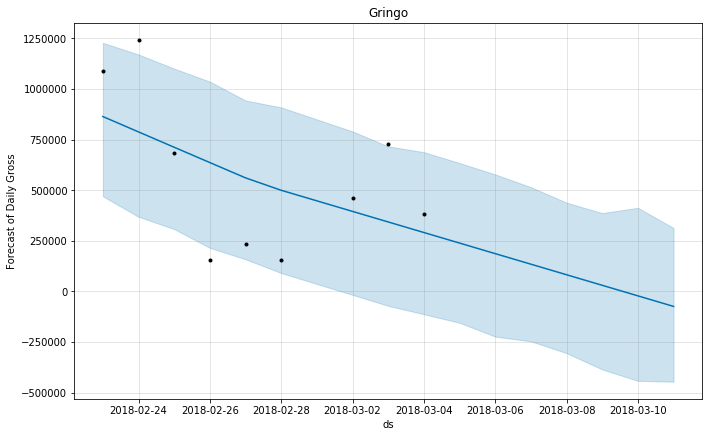

-66676.91341286199


In [30]:
movie = get_table("Every-Day")
fcast_data = forecast(movie)
weekend_sum = fcast_data[(fcast_data["ds"] >= datetime.date.today())
            & (fcast_data["day"].isin(days))]["yhat"].sum()
print(weekend_sum)